In [ ]:
import pandas as pd 
import time
import math


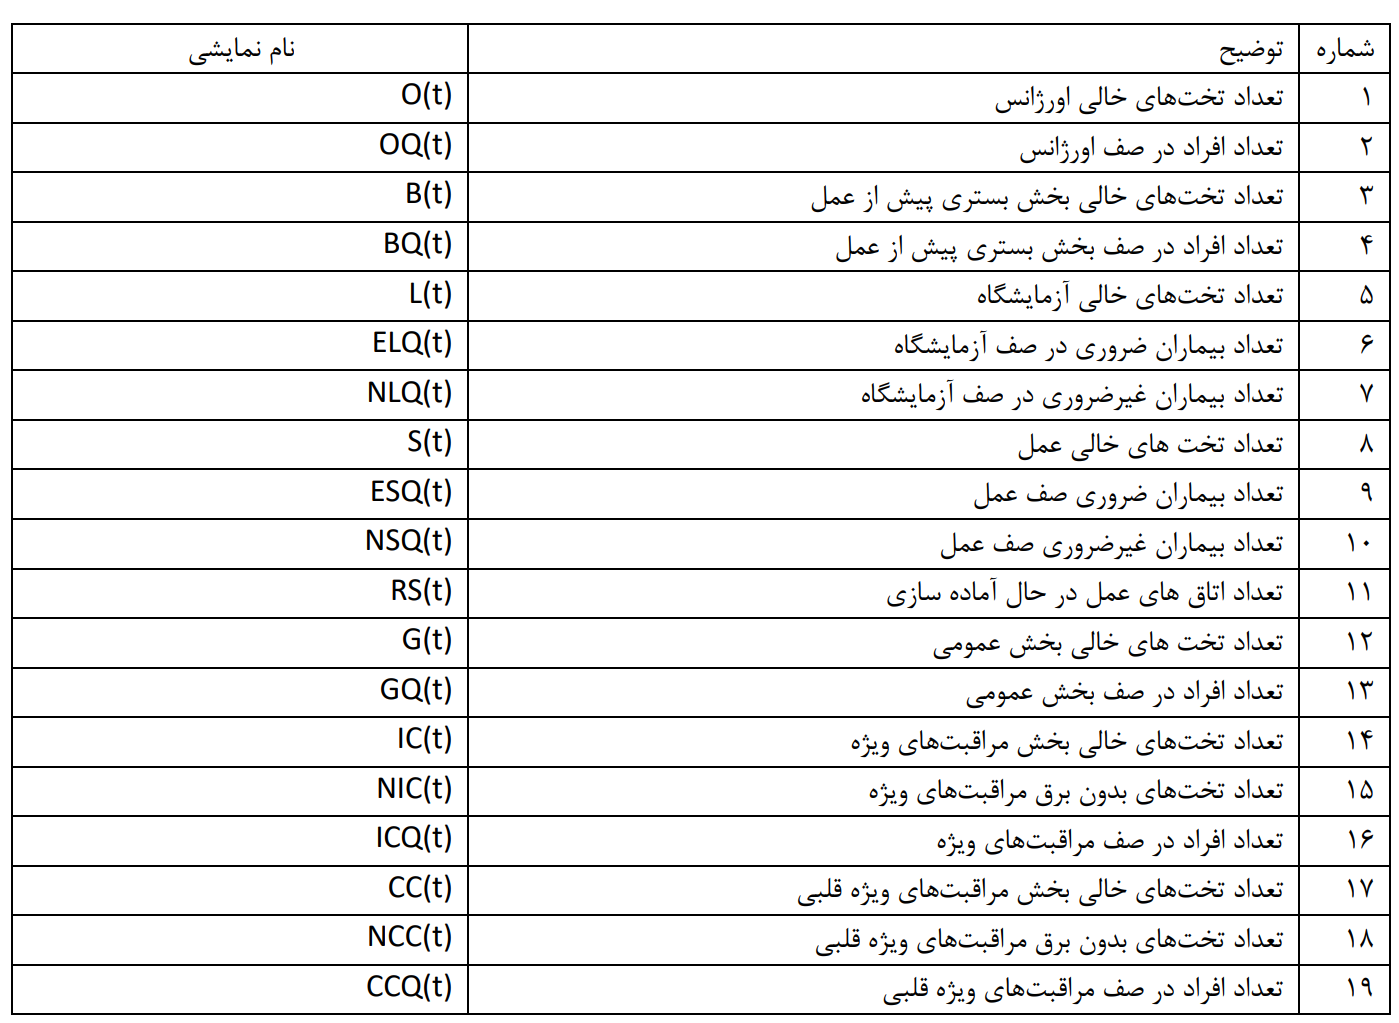

In [ ]:
stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}
for i in stats:
    print(type(i))

In [93]:
import pandas as pd 
import time
import math
def update_cumulative_stats():
    initial_tresh = 1000
    if(T < initial_tresh):
        return
    # Update efficiency of beds
    stats['eff_u'] = ((last_T - initial_tresh)*stats['eff_u'] + (T - last_T)*state_vars['U'])/(T-initial_tresh)
    stats['eff_b'] = ((last_T - initial_tresh)*stats['eff_b'] + (T - last_T)*state_vars['B'])/(T-initial_tresh)
    stats['eff_l'] = ((last_T - initial_tresh)*stats['eff_l'] + (T - last_T)*state_vars['L'])/(T-initial_tresh)
    stats['eff_s'] = ((last_T - initial_tresh)*stats['eff_s'] + (T - last_T)*state_vars['S'])/(T-initial_tresh)
    stats['eff_g'] = ((last_T - initial_tresh)*stats['eff_g'] + (T - last_T)*state_vars['G'])/(T-initial_tresh)
    stats['eff_icu'] = ((last_T - initial_tresh)*stats['eff_icu'] + (T - last_T)*state_vars['IC'])/(T-initial_tresh)
    stats['eff_ccu'] = ((last_T - initial_tresh)*stats['eff_ccu'] + (T - last_T)*state_vars['CC'])/(T-initial_tresh)
    # Update queue statistics
    for i in Q_lists:
        i['avg'] = ((last_T - initial_tresh)*i['avg'] + (T - last_T)*len(i['que']))/(T-initial_tresh)
        i['max'] = max(i['max'],len(i['que']))


state_vars = {'U':0,'UQ':0,'B':0,'BQ':0,'L':0,'ELQ':0,'NLQ':0,'S':0,'ESQ':0,'NSQ':0,'RS':0,'G':0,'GQ':0,'IC':0,'NIC':0,'ICQ':0,'CC':0,'NCC':0,'CCQ':0}
type_of_events = ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
Q_lists = { 'UQ': {'que': [], 'avg': 0, 'max': 0}, 'BQ': {'que': [], 'avg': 0, 'max': 0},
            'ELQ': {'que': [], 'avg': 0, 'max': 0}, 'NLQ': {'que': [], 'avg': 0, 'max': 0},
            'ESQ': {'que': [], 'avg': 0, 'max': 0}, 'NSQ': {'que': [], 'avg': 0, 'max': 0}, 
            'GQ': {'que': [], 'avg': 0, 'max': 0}, 'ICQ': {'que': [], 'avg': 0, 'max': 0}, 
            'CCQ': {'que': [], 'avg': 0, 'max': 0} }
patient_dict = {} # List of Patient objects that have entered the system
stats = {'fully_u':0,'eff_u':0,'eff_b':0,'eff_l':0,'eff_s':0,'eff_g':0,'eff_icu':0,'eff_ccu':0}
patient_pos = ['U','UQ','B','BQ','L','LQ','S','SQ','G','GQ','ICU','ICUQ','CCU','CCUQ']
T = 0 # Current event time
last_T = 0 # Last event time
number_of_patient = 0 # Total number of patients entered the system
FEL = [Event('END',-1,1000000,[])] # List of Event objects, sorted by time
class Patient():
    def __init__(self,arival_time,type,number):
        # Initialize patient properties
        self.arival = arival_time
        self.type = type # 'E': Emergency , 'N': normal
        self.number = number # Patient number
        self.departure = 0
        self.sur_entrance_time = 0
        self.sur_counter = 0 # Surgery count
        self.s_arrival_time = -1 # Arrival time of current section
        self.surgery_type = None # 's' simple, 'm' medium, 'c' complex
        self.current_pos = None # Current position
        # Waiting times in queues
        self.uqt = 0 # Waiting in emergency queue
        self.bqt = 0 # Waiting in bed queue
        self.lqt = 0 # Waiting in laboratory queue
        self.sqt = 0 # Waiting in surgery queue
        self.gqt = 0 # Waiting in ward(G) que
        self.icuqt = 0 # Waiting in ICU que
        self.ccuqt = 0 # Waitng in CCU que
        # Service times
        self.ut = 0 # Duration in emergency
        self.lt = 0 # Duration in laboratory
        self.st = 0 # Duration of surgery
        self.gt = 0 # Duration in ward(G)
        self.icut = 0 # Duration in ICU
        self.ccut = 0 # Duraiont in CCU
class Event():
    """
    Represents an event in the simulation.
    type: An element of ['ES','NS','LS','LE','SS','SE','RSE','GE','IC','NIC','CCE','NCCE','NS','NE']
    patient: Patient number associated with the event
    time: The time when the event occurs
    """
    def __init__(self,type,patient,time,FEL):
        self.type = type
        self.patient = patient
        self.time = time
        self.update_FEL(FEL)
    def update_FEL(self,FEL):
        # Insert event into Future Event List (FEL) sorted by time
        for i in range(len(FEL)):
            if(self.time < FEL[i].time):
                FEL.insert(i,self)
                return       
        FEL.append(self)           
def ES():
    # Check if it is a single or group entrance
    rn = 'mooz' # Placeholder value, should be edited
    if(rn < 0.995):
        # Single entrance
        print('mooz')
        if(state_vars['UQ'] < 10): # Check the emergency queue length
            # patient_number = len(patient_dict) + 1
            number_of_patient += 1
            patient_dict[number_of_patient] = Patient(T, 'E', number_of_patient) # Add new emergency patient
            if(state_vars['U'] > 0): # Check if there is an available emergency bed
                state_vars['U'] -= 1 # Update count of available emergency beds
                Event('LS', number_of_patient, T + 10, FEL) # Schedule lab start event
                patient_dict[number_of_patient].current_pos = 'U' # Update current position of patient
                patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of current position
            else: # No available emergency bed
                state_vars['UQ'] += 1 # Update length of emergency queue
                Q_lists['U']['que'].append(number_of_patient) # Add patient to emergency queue
                patient_dict[number_of_patient].current_pos = 'UQ' # Update current position of patient
                patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of current position
        else: # Emergency queue capacity is full
            stats['fully_u'] += 1 # Update fully_u statistic
    else:
        # Group entrance
        number = 2 # Generate random number
        if(number >= state_vars['U']):
            for i in range(number):
                number_of_patient += 1
                patient_dict[number_of_patient] = Patient(T, 'E', number_of_patient) # Add new emergency patients
                Event('LS', number_of_patient, T + 10, FEL) # Schedule lab start event
                patient_dict[number_of_patient].current_pos = 'U' # Update current position of the patient
                patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of the current position
            state_vars['U'] -= number # Update count of available emergency beds 
    # Generate next arrival
    interarrival_time = 0 # Generate random number for next arrival time
    Event('ES', number_of_patient + 1, T + interarrival_time, FEL)
def NS():
    number_of_patient += 1
    patient_dict[number_of_patient] = Patient(T, 'N', number_of_patient) # Add new normal patient
    if(state_vars['B'] > 0): # Check if there is an available bed in B
        state_vars['B'] -= 1 # Update count of available beds
        Event('LS', number_of_patient, T + 60, FEL) # Schedule lab start event
        patient_dict[number_of_patient].current_pos = 'B' # Update current position of the patient
        patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of the current position
    else:
        state_vars['BQ'] += 1 # Update length of B queue
        Q_lists['BQ']['que'].append(number_of_patient) # Add patient to B queue
        patient_dict[number_of_patient].current_pos = 'BQ' # Update current position of the patient
        patient_dict[number_of_patient].s_arrival_time = T # Update arrival time of the current position
    intervarrival_time = 0 # Generate random number for next arrival time
    Event('NS', number_of_patient + 1, T + intervarrival_time, FEL) # Schedule next normal patient arrival
def LS(event):
    patient_number = event.patient
    if(patient_dict[patient_number].type == 'E'): # Emergency patient!
        if(state_vars['L'] > 0): # Free lab available
            state_vars['L'] -= 1
            lab_duration = 0 # Should be edited with actual duration
            Event('LE', patient_number, T + lab_duration, FEL)
            patient_dict[patient_number].current_pos = 'L'
            patient_dict[patient_number].s_arrival_time = T
        else: # Full lab, patient should wait in queue
            state_vars['ELQ'] += 1
            Q_lists['ELQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'LQ'
            patient_dict[patient_number].s_arrival_time = T
    else: # Normal patient
        if(state_vars['L'] > 0): # Free lab available
            state_vars['L'] -= 1
            lab_duration = 0 # Should be edited with actual duration
            Event('LE', patient_number, T + lab_duration, FEL)
            patient_dict[patient_number].current_pos = 'L'
            patient_dict[patient_number].s_arrival_time = T
        else: # Full lab, patient should wait in queue
            state_vars['NLQ'] += 1
            Q_lists['NLQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'LQ'
            patient_dict[patient_number].s_arrival_time = T
def LE(event):
    patient_number = event.patient
    # Handle forward events
    if(patient_dict[patient_number] == 'E'): # Check if the patient is an emergency patient
        ss_arrival_time = 0 # Set arrival time for emergency patient
        Event('SS',patient_number,T + ss_arrival_time,FEL)
        patient_dict[patient_number].current_pos = 'U' # Update current position to 'U'
        patient_dict[patient_number].lt = T - patient_dict[patient_number].s_arrival_time # Update the leave time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    else:
        ss_arrival_time = 48 * 60 # Set standard arrival time for normal patient
        Event('SS',patient_number,T + ss_arrival_time,FEL)
        patient_dict[patient_number].current_pos = 'B' # Update current position to 'B'
        patient_dict[patient_number].lt = T - patient_dict[patient_number].s_arrival_time # Update the leave time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    # Handle backward events
    if(state_vars['ELQ'] > 0): # Check if there are emergency patients in the lab queue
        patient_number = Q_lists['ELQ']['que'].pop(0) # Get the first patient in the ELQ queue
        state_vars['ELQ'] -= 1 # Update the ELQ state variable
        lab_duration = 0 # Set lab duration (should be edited)
        Event('LE',patient_number,T + lab_duration,FEL)
        patient_dict[patient_number].current_pos = 'L' # Update current position to 'L'
        patient_dict[patient_number].lqt = T - patient_dict[patient_number].s_arrival_time # Update the lab queue time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
    elif(state_vars['NLQ']>0): # Check if there are normal patients in the lab queue
        patient_number = Q_lists['NLQ']['que'].pop(0) # Get the first patient in the NLQ queue
        state_vars['NLQ'] -= 1 # Update the NLQ state variable
        lab_duration = 0 # Set lab duration (should be edited)
        Event('LE',patient_number,T + lab_duration,FEL)
        patient_dict[patient_number].current_pos = 'L' # Update current position to 'L'
        patient_dict[patient_number].lqt = T - patient_dict[patient_number].s_arrival_time # Update the lab queue time
        patient_dict[patient_number].s_arrival_time = T # Update the arrival time
def SS(event):
    patient_number = event.patient
    sur_type = 's'  # Type of surgery
    patient_dict[patient_number].surgery_type = sur_type
    # Forward operations
    if state_vars['S'] > 0:
        state_vars['S'] -= 1
        if sur_type == 's':  # Simple surgery
            sur_duration = 0  # Duration of simple surgery
        elif sur_type == 'm':  # Medium surgery
            sur_duration = 0  # Duration of medium surgery
        else:  # Complex surgery
            sur_duration = 0  # Duration of complex surgery
        Event('ES', patient_number, T + sur_duration, FEL)
        patient_dict[patient_number].current_pos = 'S'
        patient_dict[patient_number].st += sur_duration
        patient_dict[patient_number].sur_counter += 1
        patient_dict[patient_number].sur_entrance_time = T
    else:  # No available surgery room
        if patient_dict[patient_number].type == 'E':  # Emergency patient
            state_vars['ESQ'] += 1
            Q_lists['ESQ']['que'].append(patient_number)
        else:  # Non-emergency patient
            state_vars['NSQ'] += 1
            Q_lists['NSQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'QS'
        patient_dict[patient_number].s_arrival_time = T
    # Backward operations
    if patient_dict[patient_number].type == 'E':
        if state_vars['UQ'] > 0:
            state_vars['UQ'] -= 1
            patient_number = Q_lists['UQ']['que'].pop(0)
            Event('LS', patient_number, T + 10, FEL)
            patient_dict[patient_number].current_pos = 'U'
            patient_dict[patient_number].uqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
        else:
            state_vars['U'] += 1
    else:
        if state_vars['BQ'] > 0:
            state_vars['BQ'] -= 1
            patient_number = Q_lists['BQ']['que'].pop(0)
            Event('', patient_number, T + 60, FEL)
            patient_dict[patient_number].current_pos = 'B'
            patient_dict[patient_number].bqt = T - patient_dict[patient_number].s_arrival_time
            patient_dict[patient_number].s_arrival_time = T
        else:
            state_vars['B'] += 1
def SE(event):
    patient_number = event.patient
    sur_type = patient_dict[patient_number].surgery_type
    # Forward operations
    if sur_type == 's':
        if state_vars['G'] > 0:  # Available bed in ward
            state_vars['G'] -= 1
            recovery_duration = 0  # Duration in ward
            Event('GE', patient_number, T + recovery_duration, FEL)
            patient_dict[patient_number].current_pos = 'G'
            patient_dict[patient_number].rt += recovery_duration
        else:  # No available bed, wait in GQ
            state_vars['GQ'] += 1
            Q_lists['GQ']['que'].append(patient_number)
            patient_dict[patient_number].current_pos = 'GQ'
            patient_dict[patient_number].s_arrival_time = T
    elif sur_type == 'm':
        recovery_room = 'ICU'  # Randomly generated room
        if recovery_room == 'ICU':
            if state_vars['IC'] > 0:  # Available ICU bed
                state_vars['IC'] -= 1
                recovery_duration = 0  # Duration in ICU
                Event('ICE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'IC'
                patient_dict[patient_number].s_arrival_time = T
            else:  # No available ICU bed
                state_vars['ICQ'] += 1
                Q_lists['ICQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'ICQ'
                patient_dict[patient_number].s_arrival_time = T
        elif recovery_room == 'CCU':  # Available CCU bed
            if state_vars['CC'] > 0:
                state_vars['CC'] -= 1
                recovery_duration = 0  # Duration in CCU
                Event('CCE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'CC'
                patient_dict[patient_number].s_arrival_time = T
            else:  # No available CCU bed
                state_vars['CCQ'] += 1
                Q_lists['CCQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'CCQ'
                patient_dict[patient_number].s_arrival_time = T
        else:
            if state_vars['G'] > 0:  # Available bed in ward
                state_vars['G'] -= 1
                recovery_duration = 0  # Duration in ward
                Event('GE', patient_number, T + recovery_duration, FEL)
                patient_dict[patient_number].current_pos = 'G'
                patient_dict[patient_number].rt += recovery_duration
            else:  # No available bed, wait in GQ
                state_vars['GQ'] += 1
                Q_lists['GQ']['que'].append(patient_number)
                patient_dict[patient_number].current_pos = 'GQ'
                patient_dict[patient_number].s_arrival_time = T
    else:  # Complex surgery
        is_dead = False  # Randomly generated
        if not is_dead:
            retry_sur = False  # Check if retry surgery is required
            if not retry_sur:
                heart_sur = False  # Check if operation is a heart surgery
                if not heart_sur:
                    if state_vars['IC'] > 0:  # Available ICU bed
                        state_vars['IC'] -= 1
                        recovery_duration = 0  # Duration in ICU
                        Event('ICE', patient_number, T + recovery_duration, FEL)
                        patient_dict[patient_number].current_pos = 'IC'
                        patient_dict[patient_number].s_arrival_time = T
                    else:  # No available ICU bed
                        state_vars['ICQ'] += 1
                        Q_lists['ICQ']['que'].append(patient_number)
                        patient_dict[patient_number].current_pos = 'ICQ'
                        patient_dict[patient_number].s_arrival_time = T
                else:
                    if state_vars['CC'] > 0:  # Available CCU bed
                        state_vars['CC'] -= 1
                        recovery_duration = 0  # Duration in CCU
                        Event('CCE', patient_number, T + recovery_duration, FEL)
                        patient_dict[patient_number].current_pos = 'CC'
                        patient_dict[patient_number].s_arrival_time = T
                    else:  # No available CCU bed
                        state_vars['CCQ'] += 1
                        Q_lists['CCQ']['que'].append(patient_number)
                        patient_dict[patient_number].current_pos = 'CCQ'
                        patient_dict[patient_number].s_arrival_time = T
            else:  # Retry surgery
                retry_sur_type = 's'  # Type of retry surgery
                if state_vars['S'] > 0:
                    if retry_sur_type == 's':
                        sur_duration = 0  # Duration of simple surgery
                    elif retry_sur_type == 'm':
                        sur_duration = 0  # Duration of medium surgery
                    else:
                        sur_duration = 0  # Duration of complex surgery
                    Event('ES', patient_number, T + sur_duration, FEL)
                    patient_dict[patient_number].current_pos = 'S'
                    patient_dict[patient_number].st += sur_duration
                    patient_dict[patient_number].sur_counter += 1
                    patient_dict[patient_number].sur_entrance_time = T
                else:  # No available surgery room
                    state_vars['ESQ'] += 1
                    Q_lists['ESQ']['que'].append(patient_number)
                    patient_dict[patient_number].current_pos = 'QS'
                    patient_dict[patient_number].s_arrival_time = T
    # Backward operations
    state_vars['RS'] += 1
    Event('RSE', -1, T + 10, FEL)                  
def RSE(event):
    state_vars['RS'] -= 1
    if((state_vars['ESQ'] == 0)and(state_vars['NSQ'] == 0)):
        state_vars['S'] += 1
    else:
        if(state_vars['ESQ'] > 0):
            state_vars['ESQ'] -= 1
            patient_number = Q_lists['ESQ']['que'].pop(0)
        else:
            state_vars['NSQ'] -= 1
            patient_number = Q_lists['NSQ']['que'].pop(0)
        surgery_type = patient_dict[patient_number].surgery_type
        if(surgery_type == 's'):
            surgery_duration = 0 # duration of simple surgery 
        elif(surgery_type == 'm'):
            surgery_duration = 0 # duration of medium surgery
        else:
            surgery_duration = 0 # duration of complex surgery
        Event('SE',patient_number,T + surgery_duration,FEL)
        patient_dict[patient_number].current_pos = 'S'
        patient_dict[patient_number].sqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].st += surgery_duration
def GE(event):
    patient_number = event.patient
    patient_dict[patient_number].current_pos = 'Ex'
    patient_dict[patient_number].s_arrival_time = T
    patient_dict[patient_number].departure = T
    if(state_vars['GQ'] != 0):
        state_vars['GQ'] -= 1
        patient_number = Q_lists['GQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].gqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = 0 # ward recovery duration.
        patient_dict[patient_number].gt = recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['G'] += 1
def ICE(event):
    patient_number = event.patient
    #forward
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = 0 # ward recovery duration 
        patient_dict[patient_number].gt = recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T 
    #backward
    if(state_vars['ICQ'] > 0):
        state_vars['ICQ'] -= 1
        patient_number = Q_lists['ICQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'IC'
        patient_dict[patient_number].icuqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = 0 # ICU recovery time
        patient_dict[patient_number].icut = recovery_duration
        Event('ICE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['IC'] += 1
def CCE(event):
    patient_number = event.patient
    #forward
    if(state_vars['G']>0):
        state_vars['G'] -= 1
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = 0 # ward recovery duration 
        patient_dict[patient_number].gt = recovery_duration
        Event('GE',patient_number,T + recovery_duration,FEL)
    else:
        state_vars['GQ']+=1
        Q_lists['GQ']['que'].append(patient_number)
        patient_dict[patient_number].current_pos = 'GQ'
        patient_dict[patient_number].s_arrival_time = T 
    #backward
    if(state_vars['CCQ']>0):
        state_vars['CCQ'] -= 1
        patient_number = Q_lists['CCQ']['que'].pop(0)
        patient_dict[patient_number].current_pos = 'G'
        patient_dict[patient_number].ccuqt = T - patient_dict[patient_number].s_arrival_time
        patient_dict[patient_number].s_arrival_time = T
        recovery_duration = 0 # CCU recovery time 
        patient_dict[patient_number].ccut = recovery_duration
        Event('CCQ',patient_number,T + recovery_duration, FEL)
    else:
        state_vars['CC'] += 1
     

        
    

    
        
    

        
        

        

            




            
            

    



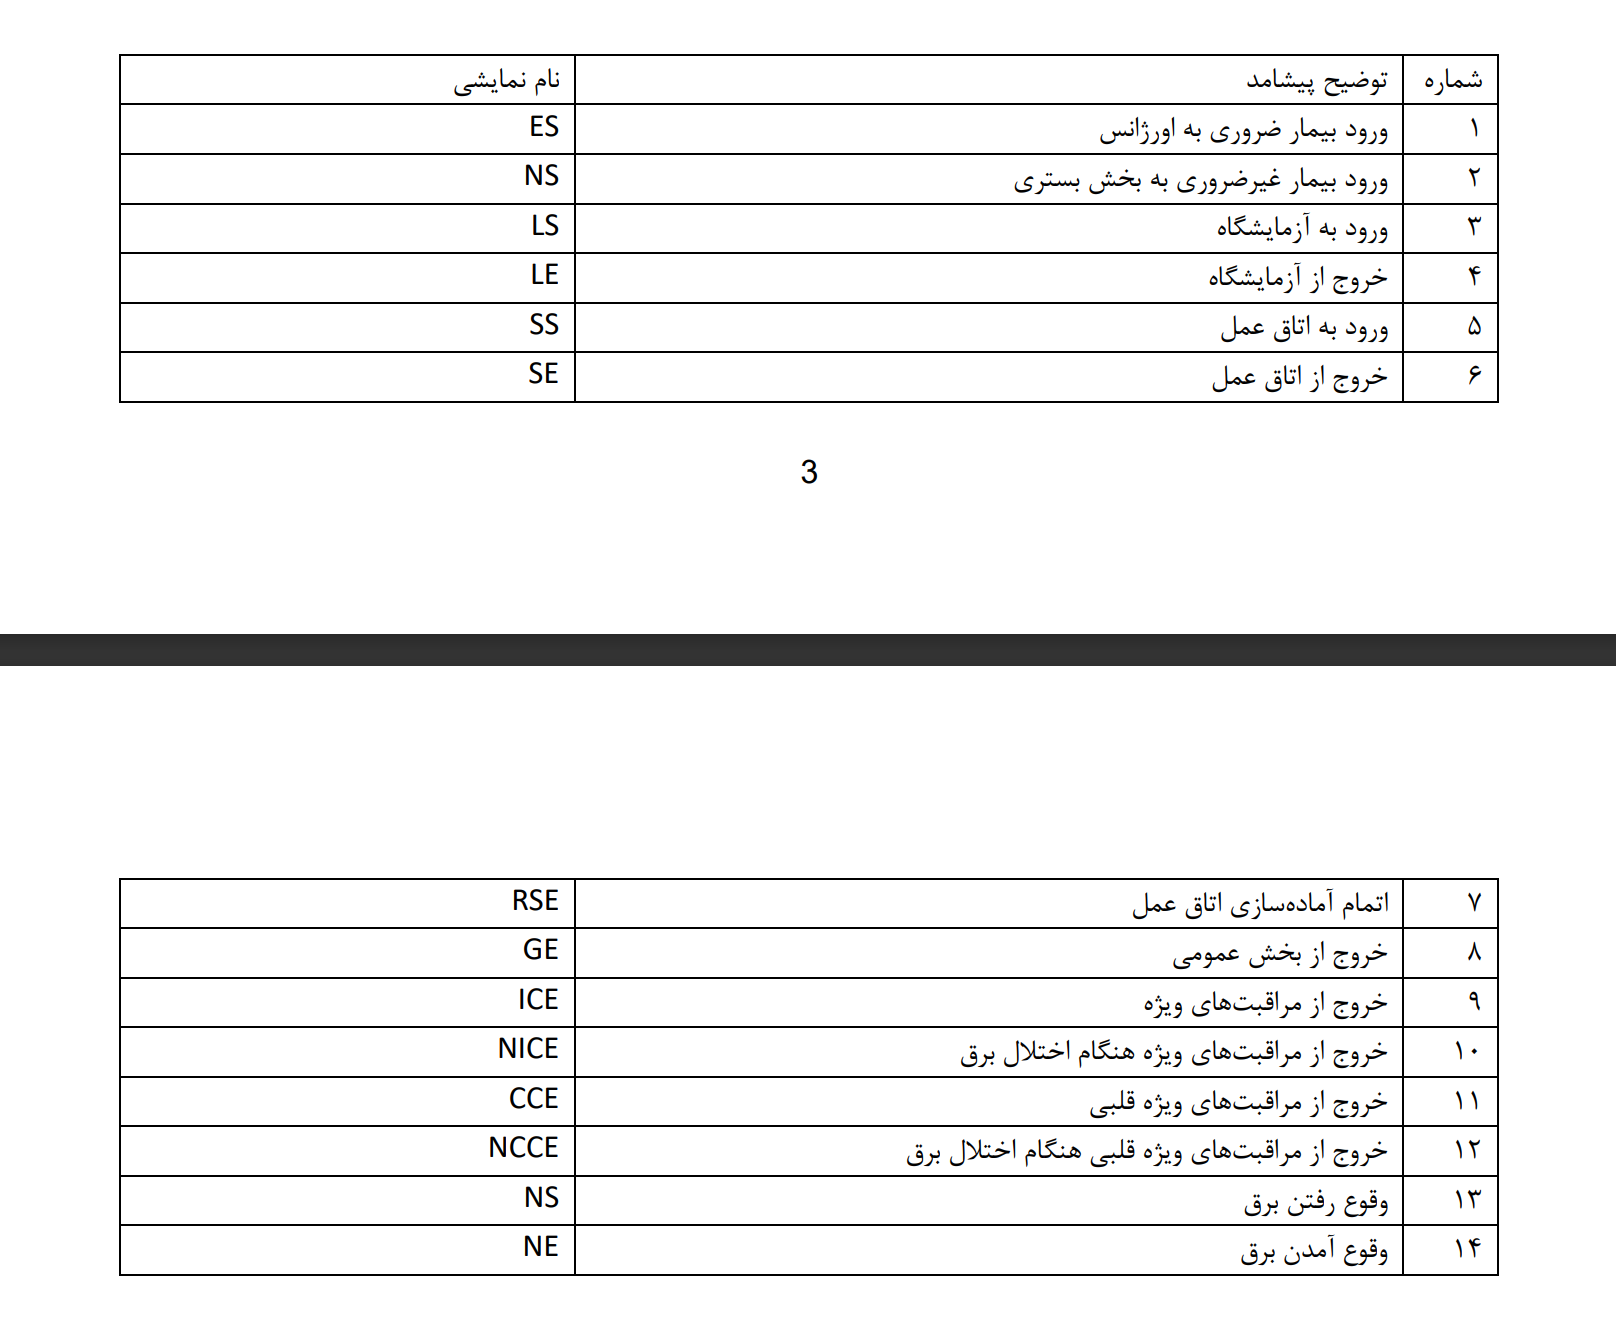